In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime
from scipy.stats import poisson
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 

from tqdm import tqdm
import os
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) # Silence Prophet if nothing major happens


In [19]:
def height_to_unixepoch(height: int) -> int:
    return height * 30 + 1598306400

def height_to_timestamp(height: int) -> datetime:
    return datetime.fromtimestamp(height_to_unixepoch(height))

def unixepoch_to_height(timestamp):
    return (timestamp - 1598306400)/30

def datetime_to_height(year:int, month:int, day:int) -> float:
    dd = int(datetime(year, month, day).strftime('%s'))
    return int((dd - 1598306400)/30)

# Some overheads to suppress Prophet output
# https://github.com/facebook/prophet/issues/223#issuecomment-326455744
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)    

def interpolate_predictions(df, fcst, feature, yhat='yhat', n_days=450):
    '''
    Takes the daily predictions from Prophet and interpolates it at the epoch level.

    Parameters
    ----------
    df (pd.DataFrame): original dataframe, sampled at epoch frequency
    fcst (pd.DataFrame): output dataframe from Prophet (must have columns ds, yhat, yhat_lower, yhat_upper)
    yhat (string): whether to use Prophet's median ('yhat'), optimistic ('yhat_upper') or pessimistic ('yhat_lower') prediction
    n_days (int): number of days to predict ahead

    Returns
    -------
    df_new (pd.DataFrame): interpolates daily Prophet prediction into an epoch-wise prediction. When feature 
                           is 'raw_bytes_network_power',  this function will also calculate the network time 
                           in epoch units. 
    '''

    df_p = fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-n_days:]

    if feature == 'raw_bytes_network_power':

        assert 'raw_bytes_network_power' in df.columns, "raw_bytes_network_power not in epoch-level dataframe"

        # Populate a new epoch-wise dataframe for the forward predictions
        df_new = pd.DataFrame()
        df_new['height'] = np.arange(df.height.max(), n_days*2880+df.height.max())
        df_new['datetime'] = df_new['height'].apply(height_to_timestamp)

        # Impute the daily prediction at 12 midnight of each day
        midnight_condition = (df_new['datetime'].dt.hour == 0) & (df_new['datetime'].dt.minute == 0) & (df_new['datetime'].dt.second == 0)
        df_new['raw_bytes_network_power'] = np.nan

        midnight_idx = np.argwhere(midnight_condition.values>0).reshape(1,-1)[0]
        for i,idx in enumerate(midnight_idx):
            df_new.loc[idx, 'raw_bytes_network_power'] = df_p.iloc[-n_days:][yhat].values[i]

        # Patch the first row of the extrapolated dataframe to the last row of the actual chain data, to facilitate interpolation
        # There will therefore be 301 interpolated points in the epoch-wise extrapolated dataframe
        df_new.loc[0, 'raw_bytes_network_power'] = df['raw_bytes_network_power'].iloc[-1]
        df_new['raw_bytes_network_power'] = df_new['raw_bytes_network_power'].interpolate(method='linear', limit_direction='forward')

        dynamic_baseline = lambda epoch: df.new_baseline_power.iloc[0] * np.exp(np.log(2)/525600/2*epoch)
        g = np.log(2)/31536000*30 # the growth rate in epoch units
        b0 = 2.888888 * 2**60 / 2**50

        # Don't forget to drop the duplicate row in df_new before concat
        df_out = pd.concat([df[['height', 'datetime', 'raw_bytes_network_power']], 
                            df_new[['height', 'datetime', 'raw_bytes_network_power']].iloc[1:]]) 
        df_out = df_out.reset_index(drop=True)
        df_out['baseline_power'] = dynamic_baseline(np.arange(len(df_out)))
        df_out['cumsum_capped_rb_power'] = df_out[['raw_bytes_network_power', 'baseline_power']].min(axis=1).cumsum()
        df_out['est_network_height'] = 15410 + 1.055*np.log(df_out['cumsum_capped_rb_power']*g/b0 + 1)/g  


    else: 

        assert feature in df.columns, "%s not in epoch-level dataframe" % feature

        # Populate a new epoch-wise dataframe for the forward predictions
        df_new = pd.DataFrame()
        df_new['height'] = np.arange(df.height.max(), n_days*2880+df.height.max())
        df_new['datetime'] = df_new['height'].apply(height_to_timestamp)

        # Impute the daily prediction at 12 midnight of each day
        midnight_condition = (df_new['datetime'].dt.hour == 0) & (df_new['datetime'].dt.minute == 0) & (df_new['datetime'].dt.second == 0)
        df_new[feature] = np.nan

        midnight_idx = np.argwhere(midnight_condition.values>0).reshape(1,-1)[0]
        for i,idx in enumerate(midnight_idx):
            df_new.loc[idx, feature] = df_p.iloc[-n_days:]['yhat'].values[i]

        # Patch the first row of the extrapolated dataframe to the last row of the actual chain data, to facilitate interpolation
        # There will therefore be 301 interpolated points in the epoch-wise extrapolated dataframe
        df_new.loc[0, feature] = df[feature].iloc[-1]
        df_new[feature] = df_new[feature].interpolate(method='linear', limit_direction='forward')

        # Don't forget to drop the duplicate row in df_new before concat
        df_out = pd.concat([df[['height', 'datetime', feature]], 
                            df_new[['height', 'datetime', feature]].iloc[1:]]) 
        df_out = df_out.reset_index(drop=True)

        if feature == 'qa_bytes_network_power':
            # if the feature is QA bytes network power, re-calculate the smoothed velocity and position estimates for the entire extrapolated df

            position = df['qa_smoothed_position_estimate'].iloc[0]
            velocity = df['qa_smoothed_velocity_estimate'].iloc[1]
            dt = 1
            alpha = 0.000164
            beta = 0.000115
            qa_recalc_pos = []
            qa_recalc_vel = []
            for k in range(len(df_out)):
                position = position + velocity * dt
                velocity = velocity
                residual = df_out['qa_bytes_network_power'].iloc[k] - position
                position = position + alpha * residual
                velocity = velocity + (beta/dt) * residual
                qa_recalc_pos.append(position)
                qa_recalc_vel.append(velocity)
            df_out['qa_smoothed_position_estimate'] = qa_recalc_pos
            df_out['qa_smoothed_velocity_estimate'] = qa_recalc_vel

            df_out = df_out[['height', 'datetime', 'qa_bytes_network_power', 'qa_smoothed_position_estimate', 'qa_smoothed_velocity_estimate']]

    return df_out

def calculate_block_reward(df):

    '''
    Given a fully extrapolated epoch-level dataframe, calculate block rewards received per day. 

    Parameters
    ----------
    df (pd.DataFrame): extrapolated epoch-level dataframe

    Returns
    -------
    df (pd.DataFrame): dataframe with simple reward, baseline reward, M (minted supply target), w (reward per wincount)
    '''

    FIL_BASE = 2e9          # only this amount in FIL will ever be issued
    M_infty = 0.55*FIL_BASE # asymptotic number of tokens
    lda = np.log(2)/6       # the minting rate corresponding to a 6 year half life
    gamma = 0.7             # the minting ratio assigned to hybrid minting
    conv_factor = 525600*2  # number of epochs in a year

    df['delta_t'] = ( df['height'] - df['height'].iloc[0])
    df['delta_t_bl'] = ( df['est_network_height'] - df['est_network_height'].iloc[0])    
    df['simple_reward'] = (1-gamma)*M_infty*gamma*(1-np.exp(-lda * df['delta_t']/conv_factor))
    df['baseline_reward'] = gamma*M_infty*gamma*(1-np.exp(-lda * df['delta_t_bl']/conv_factor))
    df['M'] =  df['simple_reward'] + df['baseline_reward']
    
    # The rolling window is arbitrary
    df['M_diff'] = df['M'].diff().rolling(2880).mean() #np.gradient(df['M'].rolling(2880).mean())
    df['w'] = df['M_diff'] / 5 

    return df[['height', 'datetime', 'M', 'w']]

def ratio_extract(num_p, num_v, denom_p, denom_v, delta_T):
    '''
    Evaluate the ratio of two variables by the alpha-beta filter
    '''
    x2a = np.log(denom_p + denom_v) 
    x2b = np.log(denom_p + denom_v + denom_v * delta_T)
    m1 = denom_v * num_p * (x2b - x2a)
    m2 = num_v * (denom_p * (x2a - x2b) + denom_v * delta_T)
    return (m1 + m2) / denom_v**2    

def predict_on_dataframe(df, column_name = 'raw_bytes_network_power', n_days=450):
    dc = df[['datetime', column_name]].reset_index(drop=True)
    dc.columns = ['ds', 'y']
    
    m = Prophet(daily_seasonality=False)
    with suppress_stdout_stderr():
        m.fit(dc)
    future = m.make_future_dataframe(periods=450)
    fcst = m.predict(future)
    return fcst


### Load data

Epoch-wise data is generated from the following query

```sql
with WinTime as (
    select 
      height,
      sum(win_count) as win_count
    from lily.block_headers
    where height > 148888
    group by height
),
Chain as (
select
    cr.height,
    first(cr.effective_network_time) AS network_height,
	avg(cr.new_baseline_power / power(2,50)) as new_baseline_power,    
	avg(cp.total_raw_bytes_power / power(2,50)) as raw_bytes_network_power, 
    avg(cp.total_qa_bytes_power / power(2,50)) as qa_bytes_network_power,
    avg(cp.qa_smoothed_position_estimate/power(2,50)/power(2,128)) as qa_smoothed_position_estimate,
    avg(cp.qa_smoothed_velocity_estimate/power(2,50)/power(2,128)) as qa_smoothed_velocity_estimate,
    avg(cr.new_reward_smoothed_position_estimate/1e18/power(2,128)) as new_reward_smoothed_position_estimate,
    avg(cr.new_reward_smoothed_velocity_estimate/1e18/power(2,128)) as new_reward_smoothed_velocity_estimate,
    avg(cr.new_reward/1e18) as new_reward,
    avg(ce.circulating_fil/1e18) as circulating_fil
    
FROM lily.chain_rewards cr
join lily.chain_powers cp on cp.height = cr.height
join lily.chain_economics ce on cr.height = ce.height
where cr.height > 148888
group by cr.height
)
select 
    Chain.height,
    Chain.network_height,
    Chain.new_baseline_power,
    Chain.raw_bytes_network_power,
    Chain.qa_bytes_network_power,
    Chain.qa_smoothed_position_estimate,
    Chain.qa_smoothed_velocity_estimate,
    Chain.new_reward_smoothed_position_estimate,
    Chain.new_reward_smoothed_velocity_estimate,
    Chain.new_reward,
    Chain.circulating_fil,
    WinTime.win_count
from Chain
join WinTime
on Chain.height = WinTime.height
order by Chain.height asc 
```

### Making forward predictions

I use Facebook Prophet to anticipate what the raw byte and quality adjusted network powers will be in the future. For convenience, I also make a projection of circulating supply, but there's no actual need for that as the circulating supply increases at a predictable and linear fashion.

In [21]:
# 0. Load data

df = pd.read_csv('data/df_height.csv')
df['datetime'] = df['height'].apply(height_to_timestamp)

# A new dataframe that's sampled exactly at midnight
# it should occur at intervals of 2880 epochs or so 
dfc = df[(df['datetime'].dt.hour == 0) & (df['datetime'].dt.minute == 0) & (df['datetime'].dt.second == 0)]

11:32:05 - cmdstanpy - INFO - Chain [1] start processing
11:32:05 - cmdstanpy - INFO - Chain [1] done processing
11:32:05 - cmdstanpy - INFO - Chain [1] start processing
11:32:06 - cmdstanpy - INFO - Chain [1] done processing
11:32:06 - cmdstanpy - INFO - Chain [1] start processing
11:32:06 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Forward prediction of real byte network capacity')

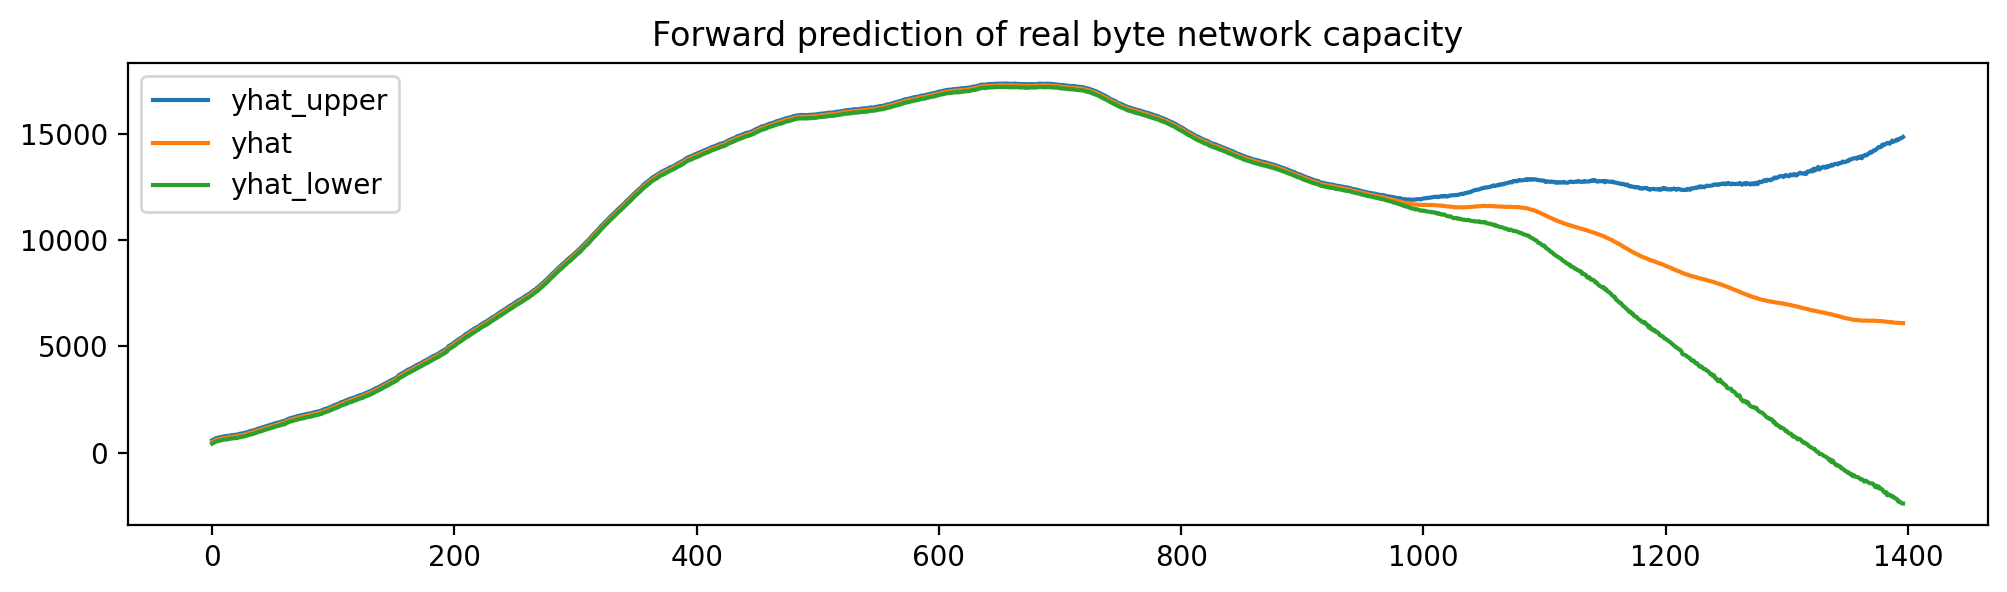

In [22]:
# 1. Run separate predictions on RB and QA network power (daily frequency)
fcst = predict_on_dataframe(dfc, 'raw_bytes_network_power')
fcst_qa = predict_on_dataframe(dfc, 'qa_bytes_network_power')
fcst_circ = predict_on_dataframe(dfc, 'circulating_fil')

fig, ax = plt.subplots(figsize=(12,3))
fcst[['yhat_upper', 'yhat', 'yhat_lower']].plot(ax=ax)
ax.set_title('Forward prediction of real byte network capacity')

In [23]:
# 2. Interpolate the predictions from daily to epoch level 
df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power')
df_new_qa = interpolate_predictions(df, fcst_qa, 'qa_bytes_network_power')
df_new_circ = interpolate_predictions(df, fcst_circ, 'circulating_fil')

Now let's check that the calculations are working as expected and that the interpolations make sense:
* There should be a second baseline crossing around Feb-Apr 2023
* The calculated and original network heights should overlap as perfectly as possible

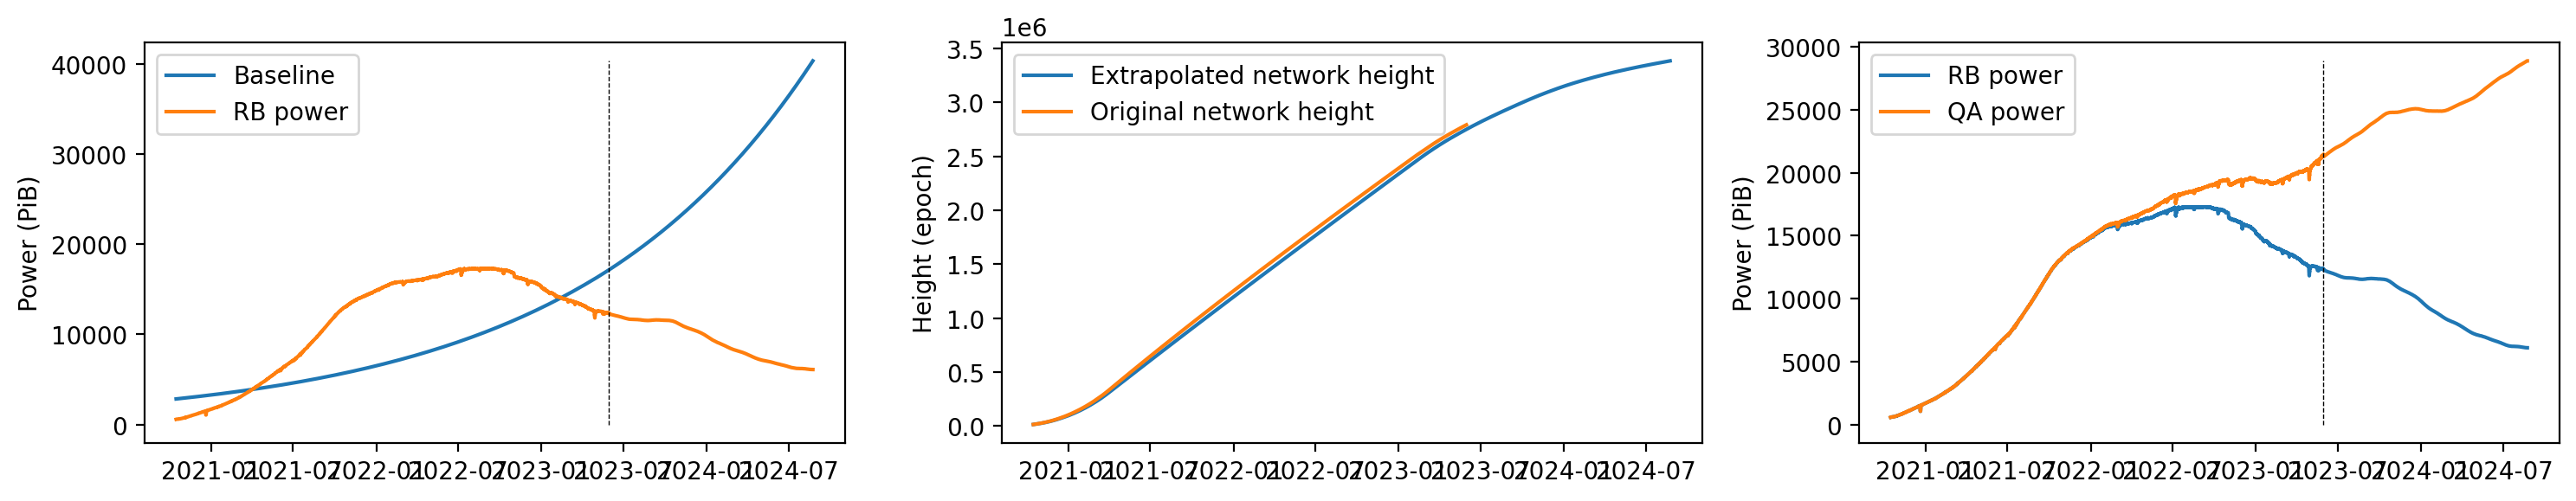

In [24]:
latest_chain_date = df.datetime.iloc[-1]

# 2a. Inspect the interpolations made 
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,3))
ax1.plot(df_new['datetime'], df_new['baseline_power'], label='Baseline')
ax1.plot(df_new['datetime'], df_new['raw_bytes_network_power'], label='RB power')
ax1.plot([latest_chain_date, latest_chain_date], [0, df_new.baseline_power.max()], 'k--', lw=0.5)
ax1.legend(loc='upper left')
ax2.plot(df_new['datetime'], df_new['est_network_height'], label="Extrapolated network height")
ax2.plot(df['datetime'], df['network_height'], label='Original network height')
ax2.legend(loc='upper left')
ax3.plot(df_new['datetime'], df_new['raw_bytes_network_power'], label='RB power')
ax3.plot(df_new_qa['datetime'], df_new_qa['qa_bytes_network_power'], label='QA power')
ax3.plot([latest_chain_date, latest_chain_date], [0, df_new_qa.qa_bytes_network_power.max()], 'k--', lw=0.5)
ax3.legend(loc='upper left')
ax1.set_ylabel('Power (PiB)')
ax2.set_ylabel('Height (epoch)')
ax3.set_ylabel('Power (PiB)')
plt.tight_layout()

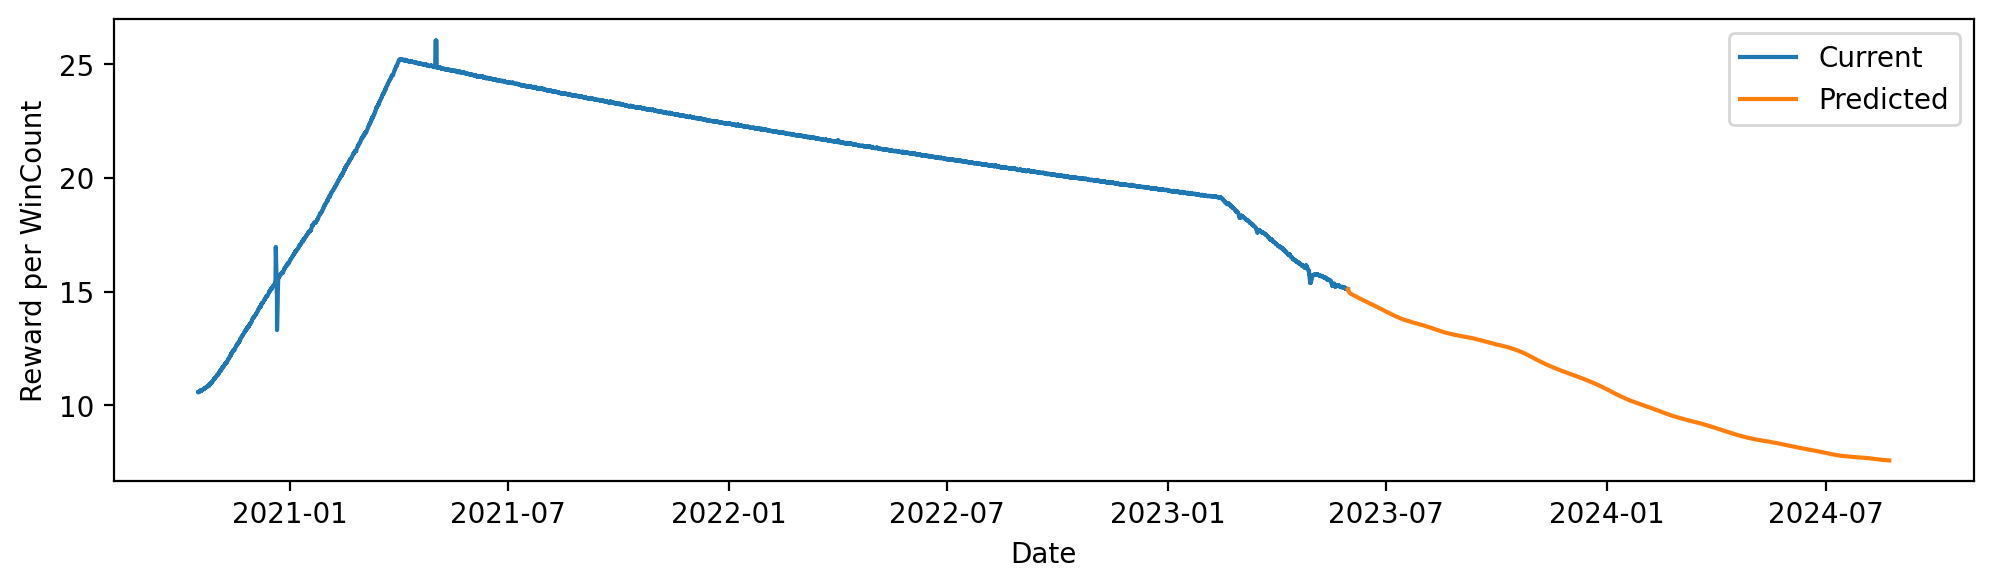

In [25]:
df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power')
df_out = calculate_block_reward(df_new)

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df_out['datetime'].iloc[0:len(df)], 1.4*df_out['w'].iloc[0:len(df)], label='Current')
ax.plot(df_out['datetime'].iloc[len(df):], 1.4*df_out['w'].iloc[len(df):], label='Predicted', color='C1')
ax.set_ylabel('Reward per WinCount')
ax.set_xlabel('Date')
ax.legend(loc='upper right')

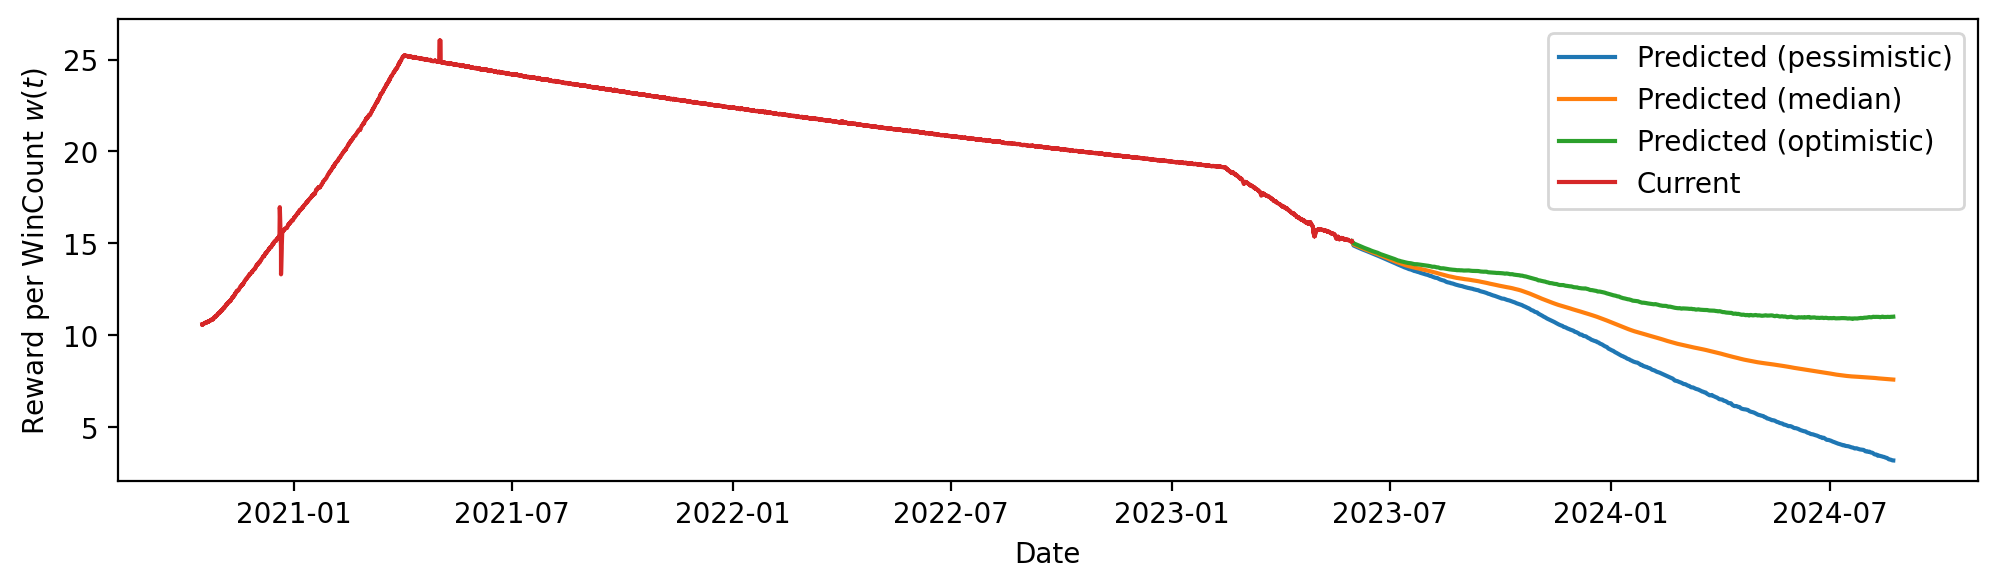

In [26]:
fig, ax = plt.subplots(figsize=(12,3))

for yh,lbl in zip(['yhat_lower', 'yhat', 'yhat_upper'], ['pessimistic', 'median', 'optimistic']):

    df_new = interpolate_predictions(df, fcst, 'raw_bytes_network_power', yh)
    df_out = calculate_block_reward(df_new)
    ax.plot(df_out['datetime'].iloc[len(df):], 1.4*df_out['w'].iloc[len(df):], label='Predicted (%s)'%lbl)

ax.plot(df_out['datetime'].iloc[0:len(df)], 1.4*df_out['w'].iloc[0:len(df)], label='Current')
ax.set_ylabel('Reward per WinCount $w(t)$')
ax.set_xlabel('Date')
ax.legend(loc='upper right')

### Calculate initial pledge

To perform a forward prediction of initial pledge, we need to: 

* recalculate the `qa_smoothed_position` estimates in our extrapolated data, at epoch level
* perform a forward prediction of the circulating supply at epoch level
    * not very controversial - circulating supply increases nearly linearly 
* perform a forward prediction of QA power and baseline power at epoch level
    * possibly a more principled way is to have some model of sector expiry
    * that way we only predict real byte network power and extrapolate to QA power as well
    * but my main priority is to use as few adjustable parameters as possible
* perform a forward prediction of WinCount at epoch level

Text(0.5, 0.98, 'QA power $\\alpha\\beta$ filter recalculation')

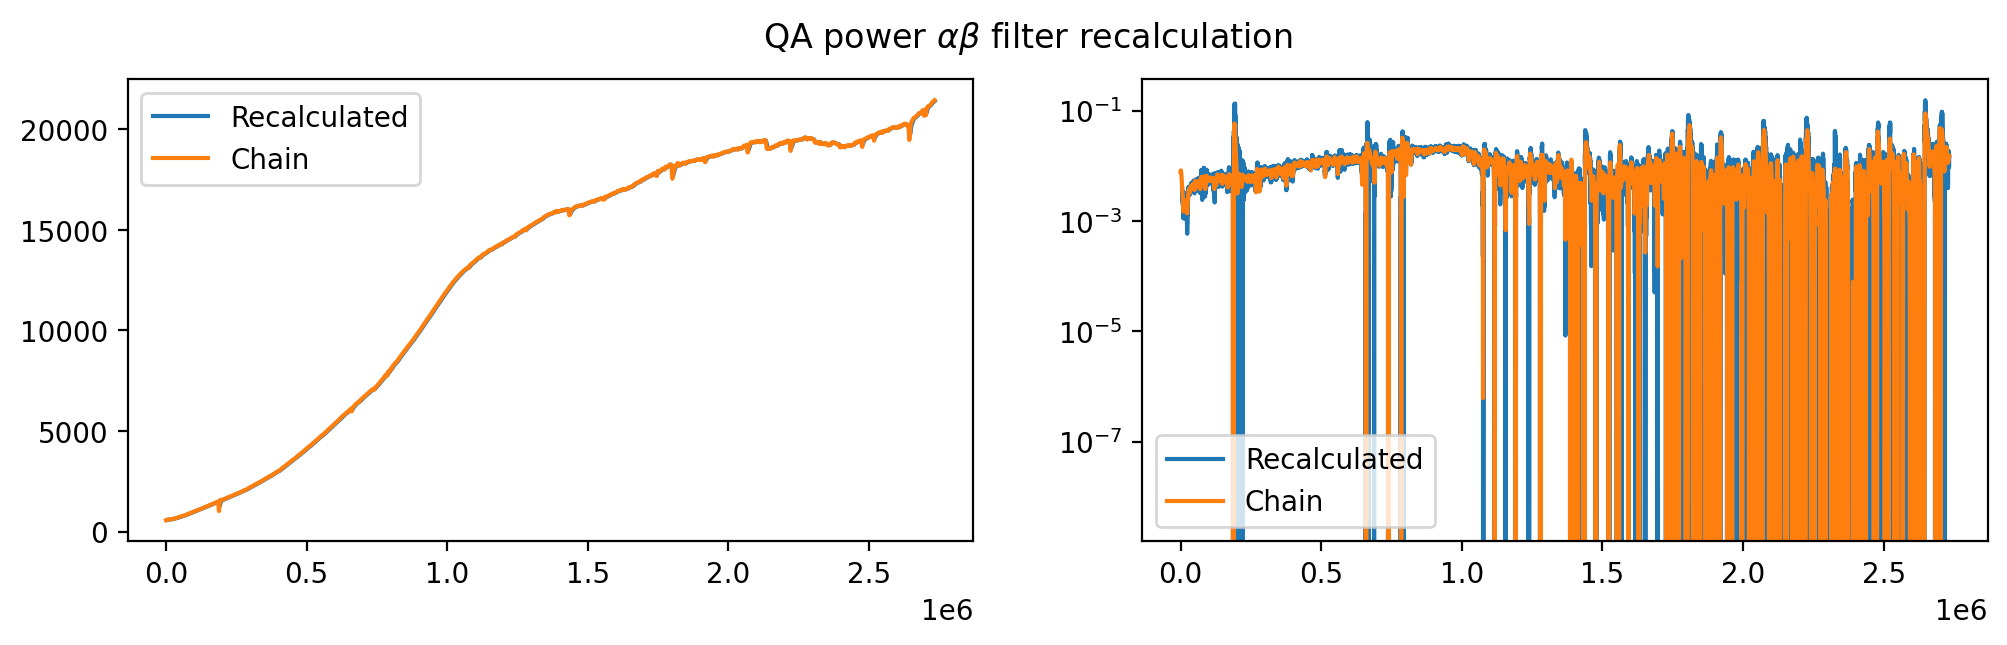

In [27]:
# (optional) Recalculate QA smoothing - this is already done in our function
position = df['qa_smoothed_position_estimate'].iloc[0]
velocity = df['qa_smoothed_velocity_estimate'].iloc[1]
dt = 1
alpha = 0.000164
beta = 0.000115
qa_recalc_pos = []
qa_recalc_vel = []
for k in range(len(df)):
    position = position + velocity * dt
    velocity = velocity
    residual = df['qa_bytes_network_power'].iloc[k] - position
    position = position + alpha * residual
    velocity = velocity + (beta/dt) * residual
    qa_recalc_pos.append(position)
    qa_recalc_vel.append(velocity)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
ax1.plot(pd.Series(qa_recalc_pos).rolling(2880*2).mean(), label='Recalculated')
ax1.plot(df['qa_smoothed_position_estimate'].values, label='Chain')

ax2.plot(pd.Series(qa_recalc_vel).rolling(2880*2).mean(), label='Recalculated')
ax2.plot(df['qa_smoothed_velocity_estimate'].values, label='Chain')
ax2.set_yscale('log')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')    
plt.suptitle('QA power $\\alpha\\beta$ filter recalculation')

Text(0.5, 0.98, 'New reward $\\alpha\\beta$ filter recalculation')

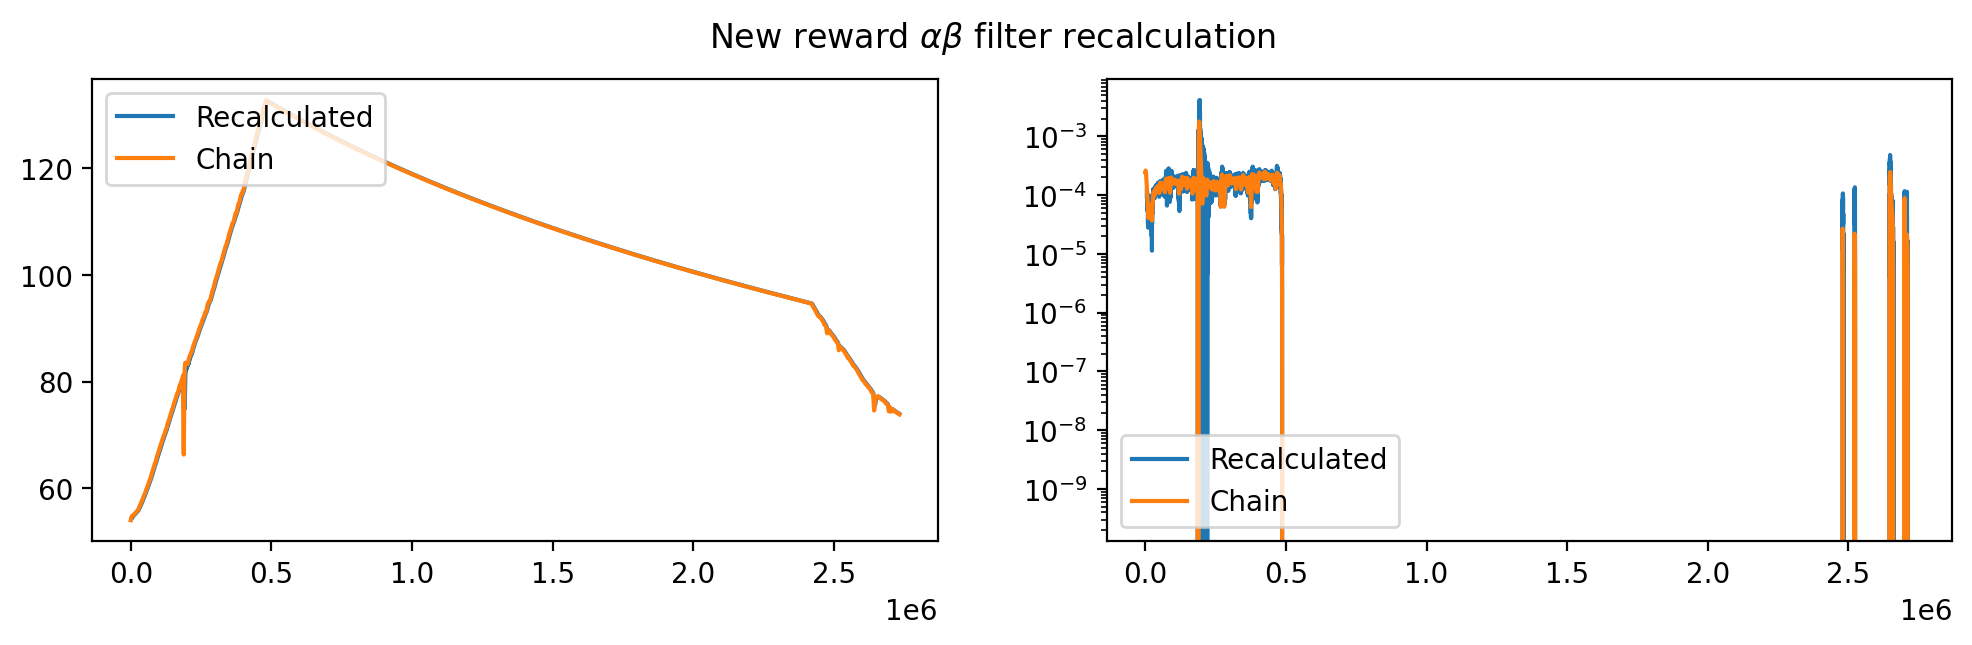

In [28]:
# (optional) Recalculate new_reward smoothing - this is already done in our function
position = df['new_reward_smoothed_position_estimate'].iloc[0]
velocity = df['new_reward_smoothed_velocity_estimate'].iloc[1]
dt = 1
alpha = 0.000164
beta = 0.000115
nr_recalc_pos = []
nr_recalc_vel = []
for k in range(len(df)):
    position = position + velocity * dt
    velocity = velocity
    residual = df['new_reward'].iloc[k] - position
    position = position + alpha * residual
    velocity = velocity + (beta/dt) * residual
    nr_recalc_pos.append(position)
    nr_recalc_vel.append(velocity)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
ax1.plot(pd.Series(nr_recalc_pos).rolling(2880*2).mean(), label='Recalculated')
ax1.plot(df['new_reward_smoothed_position_estimate'].values, label='Chain')

ax2.plot(pd.Series(nr_recalc_vel).rolling(2880*2).mean(), label='Recalculated')
ax2.plot(df['new_reward_smoothed_velocity_estimate'].values, label='Chain')
ax2.set_yscale('log')
ax1.legend(loc='upper left')
ax2.legend(loc='lower left')    

plt.suptitle('New reward $\\alpha\\beta$ filter recalculation')

In [29]:
sector_size_pib = 32*1e9/2**50
df_out = calculate_block_reward(df_new)
df_out['w'].iloc[0] = df['new_reward'].iloc[0]/7.5
df_out['w'] = df_out['w'].interpolate(method='linear', limit_direction='forward')

# Update the smoothed position and velocity estimates
position = df['qa_smoothed_position_estimate'].iloc[0]
velocity = df['qa_smoothed_velocity_estimate'].iloc[0]
dt = 1
alpha = 0.000164
beta = 0.000115
qa_recalc_pos = []
qa_recalc_vel = []
for k in range(len(df_new_qa)):
    position = position + velocity * dt
    velocity = velocity
    residual = df_new_qa['qa_bytes_network_power'].iloc[k] - position
    position = position + alpha * residual
    velocity = velocity + (beta/dt) * residual
    qa_recalc_pos.append(position)
    qa_recalc_vel.append(velocity)

position = df['new_reward_smoothed_position_estimate'].iloc[0]/7.5
velocity = df['new_reward_smoothed_velocity_estimate'].iloc[0]/7.5
dt = 1
alpha = 0.000164
beta = 0.000115
nr_recalc_pos = []
nr_recalc_vel = []
for k in range(len(df_out)):
    position = position + velocity * dt
    velocity = velocity
    # note: Lily's new_reward is about 7.5x more than df_out['w']
    residual = df_out['w'].iloc[k] - position
    position = position + alpha * residual
    velocity = velocity + (beta/dt) * residual
    nr_recalc_pos.append(position)
    nr_recalc_vel.append(velocity)

# Storage pledge is the 20 day block reward per epoch per unit of QAP    
storage_pledge = sector_size_pib * ratio_extract(
    np.array(nr_recalc_pos), 
    np.array(nr_recalc_vel),
    np.array(qa_recalc_pos),
    np.array(qa_recalc_vel),
    20 * 1440 * 2)

# Delete intermediate variables to save memory
del qa_recalc_pos, qa_recalc_vel, nr_recalc_pos, nr_recalc_vel

df_ec = pd.DataFrame()
df_ec['consensus_pledge'] = (0.3*df_new_circ['circulating_fil'] * sector_size_pib \
                             / pd.DataFrame(np.array([df_new['baseline_power'], df_new_qa['qa_bytes_network_power']]).T).max(axis=1))
df_ec['storage_pledge'] = storage_pledge
df_ec['storage_pledge'] = df_ec['storage_pledge'].rolling(2880).mean()
df_ec['storage_pledge'].iloc[0] = 0.02
df_ec['storage_pledge'] = df_ec['storage_pledge'].interpolate(method='linear', limit_direction='forward')

/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14476/2192269218.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['w'].iloc[0] = df['new_reward'].iloc[0]/7.5
/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14476/2192269218.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['w'] = df_out['w'].interpolate(method='linear', limit_direction='forward')
/var/folders/lp/k8hnm7l54kzcj3_6zp0z8d4m0000gn/T/ipykernel_14476/2844956684.py:189: RuntimeWarning: invalid value encountered in log
  x2b = np.log(denom_p + denom_v + denom_v * de

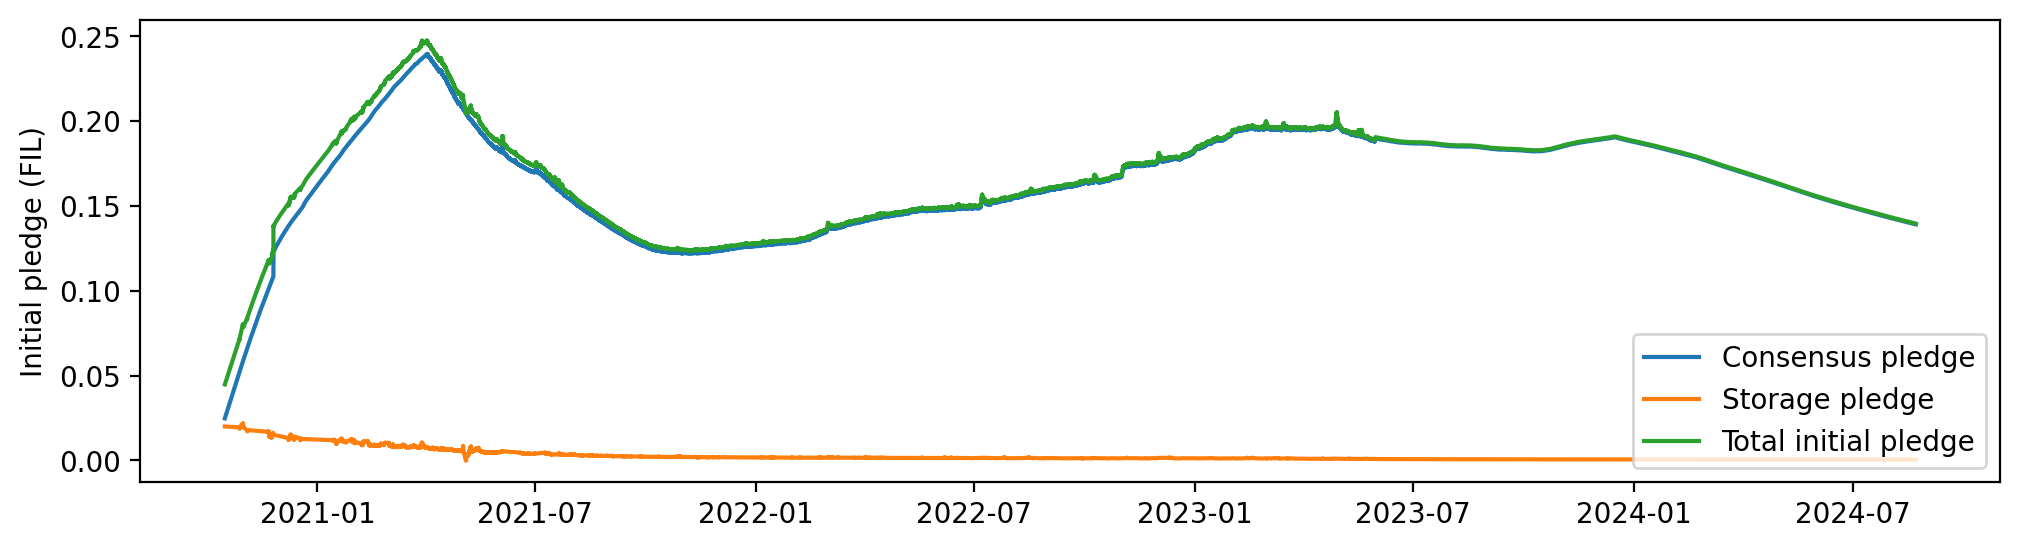

In [30]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df_new['datetime'], df_ec['consensus_pledge'], label='Consensus pledge')
ax.plot(df_new['datetime'], df_ec['storage_pledge'], label='Storage pledge')
ax.plot(df_new['datetime'], df_ec['storage_pledge'] + df_ec['consensus_pledge'], label='Total initial pledge')
ax.set_ylabel('Initial pledge (FIL)')
ax.legend(loc='lower right')

### ROI

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,5))
extended_wincount = np.concatenate([df['win_count'].values, poisson.rvs(mu=5, size=len(df_out)-len(df))])
(df_out['w']*extended_wincount).plot(ax=ax1)
(df_ec['storage_pledge'] + df_ec['consensus_pledge']).plot(ax=ax2, label='Initial pledge')
ax1.set_ylabel('Block reward (FIL per w.c.)')
ax2.set_ylabel('Initial pledge (FIL)')

### Calculating FIL on FIL

Now that we have both the initial collateral and a prediction of collected rewards, we can now check the anticipated return. 

Currently this number is an overestimate, as only 25% of the rewards are immediately issued, while 75% is locked up and disbursed over linear vesting schedule.

In [ ]:
def plot_fil_on_fil(df, df_new, df_new_qa, df_ec, n_days=180):

    '''
    Plots the FIL on FIL return, using the dataframes calculated earlier.

    Parameters
    ----------
    df_new (pd.DataFrame): epoch-level prediction of raw byte power
    df_new_qa (pd.DataFrame): epoch-level prediction of quality adjusted power
    df_ec (pd.DataFrame): calculation of the initial pledge
    n_days (int): lookahead period

    Returns
    -------
    None
    '''

    # Assume the disbursed reward is in proportion to the sector's share of the QA power 
    # (as claimed here https://filecoin.io/blog/posts/filecoin-features-block-rewards/)
    extended_wincount = np.concatenate([df['win_count'].values, poisson.rvs(mu=5, size=len(df_out)-len(df))])
    collected_reward = (sector_size_pib / df_new_qa['qa_bytes_network_power'] * df_out['w'] * extended_wincount).rolling(n_days*2880).sum() # df_new_qa['qa_bytes_network_power'], df_new['raw_bytes_network_power']
    fil_on_fil = 100*collected_reward / (df_ec['storage_pledge'] + df_ec['consensus_pledge'])

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,5))

    # When plotting we need to slice off the last n_days*2880 epochs as the rolling sum is incomplete
    ax1.plot(df_new['datetime'].iloc[n_days*2880:-n_days*2880], (df_ec['storage_pledge'] + df_ec['consensus_pledge']).iloc[n_days*2880:-n_days*2880], label='Initial collateral')
    ax1.plot(df_out['datetime'].iloc[0:len(collected_reward)-n_days*2880], collected_reward[0:-n_days*2880], label='Collected reward')
    ax2.plot(df_out['datetime'].iloc[0:len(collected_reward)-n_days*2880], fil_on_fil[0:-n_days*2880])
    ax1.set_ylabel('Value (FIL)')
    ax2.set_ylabel('FIL on FIL (%)')
    ax1.plot([df_new['datetime'].iloc[len(df)], df_new['datetime'].iloc[len(df)]], [0, 0.3], 'k--', label='Second crossover', lw=0.5)
    ax2.plot([df_new['datetime'].iloc[len(df)], df_new['datetime'].iloc[len(df)]], [0, np.max(fil_on_fil)], 'k--', label='Second crossover', lw=0.5)
    # ax2.set_ylim([0,25])
    ax1.set_ylim([0,0.3])
    ax1.legend(loc='upper left')
    plt.suptitle('%s day FIL-on-FIL return for a 32 GiB sector' % n_days)
    plt.tight_layout()

In [ ]:
plot_fil_on_fil(df, df_new, df_new_qa, df_ec, 180)
plt.xlim([pd.to_datetime('2022-06-01'), pd.to_datetime('2023-04-01')])
plt.ylim([0,50])

In [ ]:
plot_fil_on_fil(df, df_new, df_new_qa, df_ec, 360)
plt.xlim([pd.to_datetime('2022-06-01'), pd.to_datetime('2023-04-01')])
plt.ylim([0,150])